In [1]:
pip install pytorch-lightning scikit-learn scipy lightly rsatoolbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 461.6/461.6 KB 11.9 MB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.7/208.7 KB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 80.0 MB/s eta 0:00:0000:0100:01
  Created wheel for petname: filename=petname-2.2-py3-none-any.whl size=8160 sha256=8da89d4f7b861db442c867d94827993cac84041f0e8ea8fbc3b3ac8a4f6df6ea
  Stored in directory: /home/jovyan/.cache/pip/wheels/7e/de/a7/7b5fb3004811da4c6e792438fa93cc4fccc14a9f4df5d0768d
Successfully built petname
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch-geometric 2.0.3 requires rdflib, which is not installed.
tensorflow 2.6.3 r

In [254]:
import os
import torchvision
import PIL
import lightly
import torch
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import tqdm
import logging
import rsatoolbox as rsa
import pytorch_lightning as pl
from matplotlib import pyplot as plt
from torchvision.models import alexnet
from lightly.models.modules.heads import SimCLRProjectionHead
from lightly.loss import NTXentLoss
from DeepMouseTrap.neural_data.neural_data import AllenBrainObservatory

In [291]:
neural_data = AllenBrainObservatory({'signficant_running':False,'image_selective':True,'splithalf_r':0.3})
neural_data.get_neural_rdms(subset = neural_data.cell_subset, group_vars =['cortical_area'])['VISp'][:118,:118].shape

(118, 118)

In [255]:
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
def setup_logger(name, log_file, level=logging.INFO):
    """To setup as many loggers as you want"""

    handler = logging.FileHandler(log_file)        
    handler.setFormatter(formatter)

    logger = logging.getLogger(name)
    logger.setLevel(level)
    logger.addHandler(handler)

    return logger

In [256]:
class SimCLRModel(pl.LightningModule):
    def __init__(self):
        super().__init__()

        AlexNet = alexnet()
        self.backbone = torch.nn.Sequential(*list(AlexNet.children())[:-1])
        #print(self.backbone)
        hidden_dim = 9216
        self.projection_head = SimCLRProjectionHead(hidden_dim, hidden_dim, 128)

        self.criterion = NTXentLoss(temperature=0.1)

    def forward(self, x):
        h=self.backbone(x).flatten(start_dim=1)
        z = self.projection_head(h)
        return z

    def training_step(self, batch, batch_idx):
        (x0, x1), _, _ = batch
        z0 = self.forward(x0)
        z1 = self.forward(x1)
        loss = self.criterion(z0, z1)
        self.log("train_loss_ssl", loss)
        return loss

    def configure_optimizers(self):
        optim = LARS(params=self.parameters(),lr=1e-2,momentum=0.9,weight_decay=1e-6)
        #scheduler = LinearWarmupCosineAnnealingLR(optimizer = optim,warmup_epochs=10,max_epochs=200)
        return [optim]#, [scheduler]
    
    def train_dataloader(self):
        collate_fn = lightly.data.SimCLRCollateFunction(input_size=64,gaussian_blur=0.0)
        return DataLoader(
                        lightly.data.LightlyDataset('../datasets/ImageNet64/train/'),
                        batch_size=512,
                        shuffle=True,
                        collate_fn=collate_fn,
                        drop_last=True,
                        num_workers=8,
                        pin_memory=False
                    )

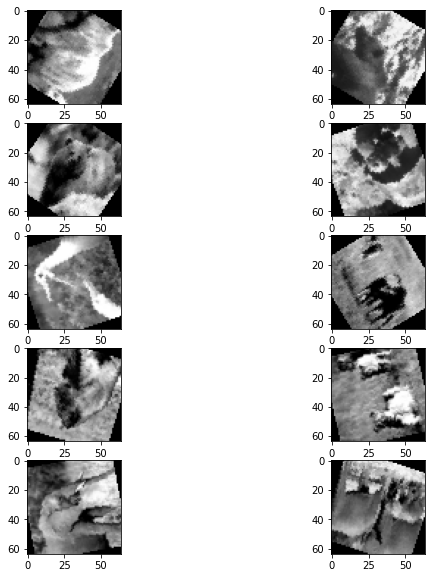

In [396]:
class NaturalScenes(torch.utils.data.Dataset):
    def __init__(self,file_path = 'DeepMouseTrap/neural_data/brain_observatory/stimulus_set.npy'):
        self.ims = np.load(file_path)
        self.size = 118
        self.transform = torchvision.transforms.Compose([torchvision.transforms.Resize([256]),torchvision.transforms.CenterCrop(224),torchvision.transforms.Resize([64,64]),torchvision.transforms.RandomRotation((-360,360)),torchvision.transforms.ToTensor()])
    def __len__(self):
        return self.size
    def __getitem__(self, index):
        im = PIL.Image.fromarray(self.ims[index])
        im = self.transform(im)
        im = im.unsqueeze(0)
        return im
stimulus = NaturalScenes()
fig,axs = plt.subplots(5,2,figsize=(10,10))
im=0
for i in range(5):
    for j in range(2):
        axs[i,j].imshow(stimulus[im].squeeze(0).permute(1,2,0))
        im+=1

In [403]:
vis_layers = ['VISp','VISl','VISal','VISam','VISpm','VISrl']
LAYER_MAPPING = {2:'conv1',5:'conv2',8:'conv3',10:'conv4',12:'conv5'}
def extract_model_response(model=alexnet(pretrained=True).features,n_trials=50):
    model_activations = {layer:[] for layer in LAYER_MAPPING.values()}
    for i in tqdm.notebook.tqdm(range(n_trials)):
        stimulus = NaturalScenes()
        for ind,layer in LAYER_MAPPING.items():
            activation_model=model[:ind]
            # activation_model = model.features[:ind]
            activation_model.eval()
            activations = []
            for j in range(len(stimulus)):
                activation = activation_model(stimulus[j])
                # if j==0:
                #     print(activation.shape)
                activations.append(np.mean(activation.detach().numpy().squeeze(axis=0),axis=(1,2)))
            activations = np.stack(activations)
            #print(activations.shape)
            model_activations[layer].append(activations)
    return {layer:np.stack(activations) for layer,activations in model_activations.items()}
def extract_neural_response(layer):
    neural_resp=AllenBrainObservatory({'signficant_running':False,'image_selective':True,'splithalf_r':0.3})
    cells = neural_resp.cell_metadata[neural_resp.cell_metadata['cortical_area']==layer]
    neural_data = pd.read_csv('DeepMouseTrap/neural_data/brain_observatory/cell_response_average.csv').set_index('cell_specimen_id').filter(items = neural_resp.cell_metadata.index,axis=0)
    per_specimen_response = {}
    for specimen in np.unique(cells['donor_name']):
        #print(specimen)
        specimen_population = cells[cells['donor_name'] == specimen].index
        response = neural_data.filter(items = specimen_population,axis=0).drop(columns=['118']).to_numpy().T
        odd_response = neural_data.filter(items = specimen_population,axis=0).drop(columns=['118']).to_numpy().T
        #print(f'Response shape: {even_response.shape}')                                                             
        per_specimen_response[specimen] = response
    
    spec_pop_sizes = [per_specimen_response[specimen].shape[1] for specimen in per_specimen_response.keys()]
    # print(f' Number of Specimen before filtering: {len(spec_pop_sizes)}')
    # print(f'Number of Neurons before filtering: {sum(spec_pop_sizes)}')
    threshold = np.percentile(spec_pop_sizes,75)
    # print(f'Filtering for specimen with population size above {threshold}')
    
    per_specimen_response = {specimen:response for specimen,response in per_specimen_response.items() if response.shape[1] >= threshold}
    num_neurons = sum([per_specimen_response[specimen].shape[1] for specimen in per_specimen_response.keys()])
#     print(f'Number of Specimen after filtering: {len(per_specimen_response)}')
#     print(f'Number of Neurons after filtering: {num_neurons}')
    
    # per_specimen_response_train = {specimen:response[train_ims] for specimen,response in per_specimen_response.items()}
    # per_specimen_response_test = {specimen:response[test_ims] for specimen,response in per_specimen_response.items()}
    # print(type(per_specimen_response_even))
    return per_specimen_response

In [404]:
def calculate_rdm(activations,source = 'model'):
    if source == 'model':
        n_rep,nCond,nVox=activations.shape
        activations = np.reshape(activations, (activations.shape[0]*activations.shape[1],activations.shape[2]))
    else:
        nCond,nVox = activations.shape
        n_rep = 50
        activations = np.repeat(activations, n_rep, axis=0)
        activations += 1e-3*np.random.randn(*activations.shape)
    print(activations.shape)
    conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
    print(conds.shape)
    sessions = np.tile(np.arange(n_rep), 118)
    print(sessions.shape)
    conds = np.repeat(conds, n_rep)
    print(conds.shape)
    chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
    obs_des = {'conds': conds, 'sessions': sessions}
    des = {'subj': 1}
    dataset = rsa.data.Dataset(
        measurements=activations,
        descriptors=des,
        obs_descriptors=obs_des,
        channel_descriptors=chn_des)
    noise_prec_diag = rsa.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='diag')
    rdm_crossnobis = rsa.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis',noise=noise_prec_diag)
    return rdm_crossnobis
def compare_rdm(rdm1, rdm2,metric='cosine_cov'):
    return rsa.rdm.compare(rdm1,rdm2,method=metric)

def rsa_model2spec(model,vis_layer,metric='cosine_cov'):
    model_activations = extract_model_response(model)
    neural_activations = extract_neural_response(vis_layer)
    #print(len(neural_activations.keys()))
    per_layer_rsa = {layer:[] for layer in model_activations.keys()}
    for layer in model_activations.keys():
        model_rdm = calculate_rdm(model_activations[layer])
        for specimen in neural_activations.keys():
            specimen_rdm = calculate_rdm(neural_activations[specimen])
            sim = compare_rdm(model_rdm,specimen_rdm,metric)
            per_layer_rsa[layer].append(sim[0][0])
    return per_layer_rsa
model_activations = extract_model_response()
for layer,activations in model_activations.items():
    print(layer)
    calculate_rdm(activations)

  0%|          | 0/50 [00:00<?, ?it/s]

conv1
(5900, 64)
(118,)
(5900,)
(5900,)


LinAlgError: Singular matrix

In [405]:
model_activations['conv1']

array([[[6.50614640e-03, 0.00000000e+00, 7.75698805e-03, ...,
         1.08683802e-01, 5.06380320e-01, 1.35963395e-01],
        [1.53863719e-02, 0.00000000e+00, 1.34851160e-02, ...,
         1.08200908e-01, 3.32398832e-01, 1.66670814e-01],
        [2.61126626e-02, 0.00000000e+00, 1.20938597e-02, ...,
         1.57268614e-01, 5.06274760e-01, 1.45352110e-01],
        ...,
        [5.59524111e-02, 0.00000000e+00, 1.27016790e-02, ...,
         3.27566922e-01, 7.03889787e-01, 2.06087947e-01],
        [1.95957143e-02, 0.00000000e+00, 8.10942333e-03, ...,
         1.44698247e-01, 3.98175120e-01, 2.66449749e-01],
        [2.19059549e-02, 0.00000000e+00, 1.13917785e-02, ...,
         2.00838059e-01, 5.86987376e-01, 2.07429349e-01]],

       [[6.51894417e-03, 0.00000000e+00, 6.88536279e-03, ...,
         1.68644711e-01, 3.47744644e-01, 1.35295689e-01],
        [2.77383197e-02, 0.00000000e+00, 1.52266780e-02, ...,
         7.83629119e-02, 4.14758235e-01, 2.42519736e-01],
        [2.15035528e-02, 

In [400]:
real_model = SimCLRModel().load_from_checkpoint(f'rep_data/real2/checkpoints/last.ckpt')
real_comps = rsa_model2spec(alexnet(pretrained=True).features,"VISp")
real_comps_df = pd.DataFrame.from_dict(real_comps)
real_comps_df.describe()

  0%|          | 0/50 [00:00<?, ?it/s]

(5900, 64)
(118,)
(5900,)
(5900,)


LinAlgError: Singular matrix

In [306]:
domain_rsa = {'sketch':None,'infograph':None,'clipart':None,'quickdraw':None,'paint':None,'real':None}
for domain in tqdm.notebook.tqdm(domain_rsa.keys(),desc="Domains",position=0,leave=False):
    per_layer_rsa = {vis_layer:None for vis_layer in vis_layers}
    model = SimCLRModel().load_from_checkpoint(f'rep_data/{domain}2/checkpoints/last.ckpt')
    for vis_layer in tqdm.notebook.tqdm(per_layer_rsa.keys(),desc="VIS Layer", position=1,leave=False):
        comps = rsa_model2spec(model.backbone,vis_layer)
        comps_df = pd.DataFrame.from_dict(comps)
        per_layer_rsa[vis_layer]=comps_df
    domain_rsa[domain] = per_layer_rsa

Domains:   0%|          | 0/6 [00:00<?, ?it/s]

VIS Layer:   0%|          | 0/6 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [271]:
domain_rsa2 = {layer:pd.concat([domain_rsa[domain][layer].assign(Domain=domain) for domain in domain_rsa.keys()]) for layer in vis_layers}
domain_rsa2

{'VISp':        conv1     conv2     conv3     conv4     conv5  Domain
 0   0.219584  0.219914  0.219902  0.219721  0.219731  sketch
 1   0.143685  0.143928  0.141521  0.145748  0.142533  sketch
 2   0.090119  0.095173  0.090370  0.094464  0.090593  sketch
 3   0.214584  0.212328  0.214021  0.212913  0.212430  sketch
 4   0.134703  0.139687  0.139428  0.138586  0.138240  sketch
 ..       ...       ...       ...       ...       ...     ...
 24  0.084556  0.082859  0.082811  0.082006  0.083724    real
 25  0.174832  0.171193  0.173135  0.169836  0.173290    real
 26  0.170070  0.171674  0.170150  0.169569  0.170647    real
 27  0.228670  0.228886  0.228178  0.228703  0.229267    real
 28  0.209025  0.210968  0.213228  0.211820  0.212432    real
 
 [174 rows x 6 columns],
 'VISl':        conv1     conv2     conv3     conv4     conv5  Domain
 0   0.122514  0.121552  0.123075  0.122392  0.123667  sketch
 1   0.154713  0.156858  0.154293  0.156601  0.157935  sketch
 2   0.126087  0.127724  0.

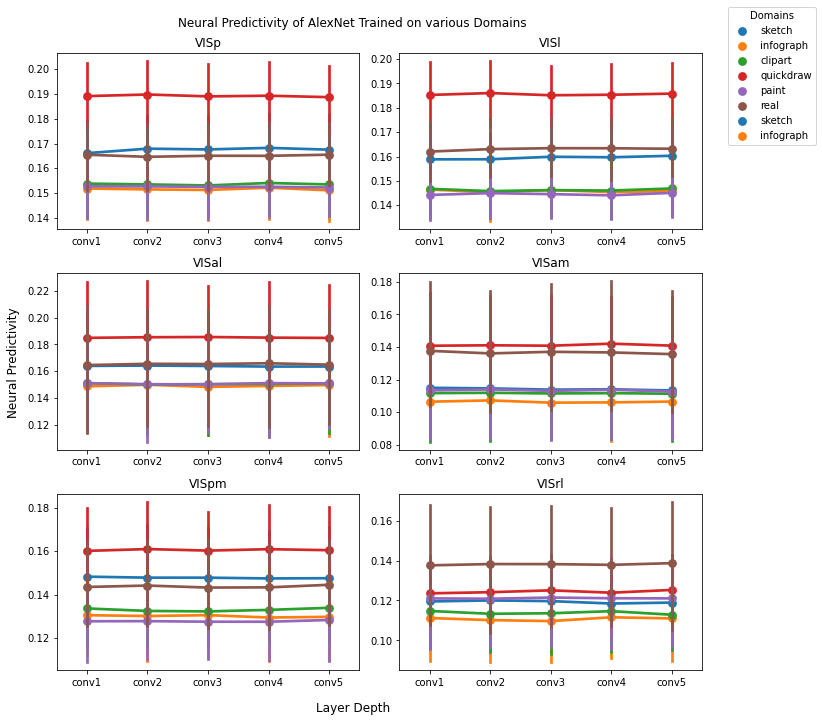

In [272]:
fig,axs = plt.subplots(3,2,figsize=(10,10))
#fig.subplots_adjust(hspace=0.3, wspace=0.1)
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISp'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[0,0])
plot.set(title='VISp',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',legend = False,
                     ax=axs[0,1])
plot.set(title='VISl',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISal'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[1,0])
plot.set(title='VISal',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISam'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[1,1])
plot.set(title='VISam',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISpm'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[2,0])
plot.set(title='VISpm',xlabel=None,ylabel=None)
plot.get_legend().remove()
plot = sns.pointplot(data=pd.melt(domain_rsa2['VISrl'],id_vars='Domain',var_name='Layer Depth',value_name='Neural Predictivity'),
                     x='Layer Depth',
                     y='Neural Predictivity',
                     hue='Domain',
                     legend = False,
                     ax=axs[2,1])
plot.set(title='VISrl',xlabel=None,ylabel=None)
plot.get_legend().remove()
fig.suptitle("Neural Predictivity of AlexNet Trained on various Domains")
fig.supxlabel('Layer Depth')
fig.supylabel('Neural Predictivity')
fig.tight_layout()
# labels_handles = {
#   label: handle for ax in fig.axes for handle, label in zip(*ax.get_legend_handles_labels())
# }
lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes]
lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# finally we invoke the legend (that you probably would like to customize...)

fig.legend(lines[:8], labels[:8],loc='upper right',bbox_to_anchor=(1.15,1),title='Domains')
plt.show()

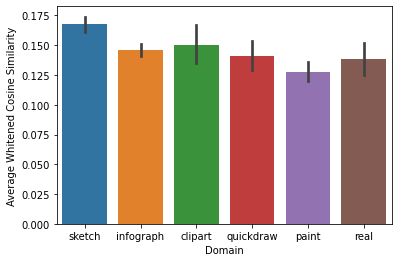

In [263]:
domain_rsa_df = {vis_layer:pd.concat([domain_rsa[domain][vis_layer].assign(Domain=domain) for domain,vis_layer in zip(domain_rsa.keys(),domain_rsa[domain].keys())]) for vis_layer in domain_rsa['real'].keys()}
domain_rsa_df['VISp']
fig,ax = plt.subplots()
sns.barplot(data=pd.melt(domain_rsa_df['VISp'],id_vars="Domain",var_name="Layer Depth",value_name="Average Whitened Cosine Similarity"),x="Domain",y="Average Whitened Cosine Similarity",ax=ax)
fig.set_facecolor('white')

In [264]:
for domain in domain_rsa.keys():
    print(domain)
    print(domain_rsa[domain]['VISal'].describe())

sketch
          conv1     conv2     conv3     conv4     conv5
count  8.000000  8.000000  8.000000  8.000000  8.000000
mean   0.163894  0.164155  0.163835  0.163393  0.163427
std    0.062475  0.062493  0.062047  0.062146  0.062315
min    0.075054  0.074948  0.074553  0.073780  0.071656
25%    0.108088  0.108354  0.110418  0.108948  0.110979
50%    0.186448  0.187797  0.185457  0.185857  0.184487
75%    0.205169  0.205562  0.203159  0.203312  0.203955
max    0.242178  0.241113  0.243143  0.242305  0.241598
infograph
          conv1     conv2     conv3     conv4     conv5
count  8.000000  8.000000  8.000000  8.000000  8.000000
mean   0.148628  0.149797  0.148190  0.148921  0.149549
std    0.055573  0.054970  0.055607  0.055032  0.054867
min    0.078765  0.081752  0.079070  0.080475  0.079118
25%    0.090929  0.092067  0.090236  0.090757  0.092262
50%    0.166688  0.166534  0.165477  0.167602  0.168106
75%    0.188387  0.189967  0.189177  0.187325  0.187809
max    0.211778  0.211124  0.21

In [141]:
n_rep = 3
m_noisy = np.repeat(model_responses_trained['conv5'], n_rep, axis=0)
m_noisy += 1e-3*np.random.randn(*m_noisy.shape)

conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
sessions = np.tile(np.arange(n_rep), 118)
conds = np.repeat(conds, n_rep)
obs_des = {'conds': conds, 'sessions': sessions}

des = {'subj': 1}

dataset = rsa.data.Dataset(
    measurements=m_noisy,
    descriptors=des,
    obs_descriptors=obs_des,
    channel_descriptors=chn_des)

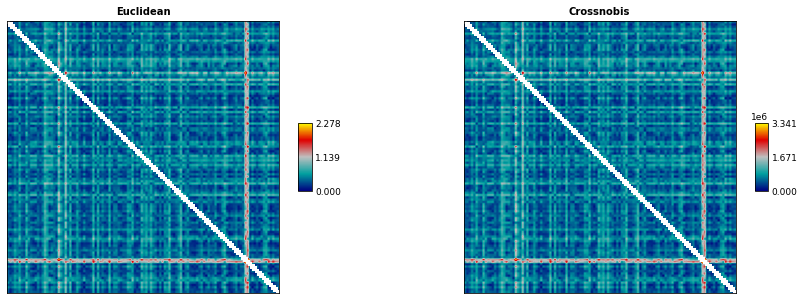

In [142]:
noise_prec_diag = rsa.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='diag')
rdm_euc = rsa.rdm.calc_rdm(dataset, descriptor='conds', method='euclidean')
rdm_maha_shrink = rsa.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis',noise=noise_prec_diag)
rsa.vis.show_rdm(
    rsa.rdm.RDMs(
        np.concatenate(
            [rdm_euc.get_matrices(),
             rdm_maha_shrink.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Euclidean', 'Crossnobis'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)[0].set_facecolor('white')

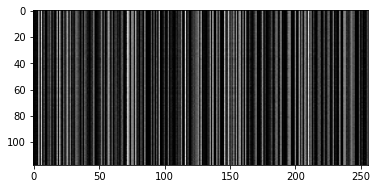

In [103]:
model_responses_untrained = extract_model_response(model=alexnet(pretrained=False),stimulus=stimulus)
plt.imshow(model_responses_untrained['conv5'],cmap='gray')
nCond = model_responses_untrained['conv5'].shape[0]
nVox = model_responses_untrained['conv5'].shape[1]

In [143]:
n_rep = 3
m_noisy = np.repeat(model_responses_untrained['conv5'], n_rep, axis=0)
m_noisy += 1e-3*np.random.randn(*m_noisy.shape)

conds = np.array(['cond_%02d' % x for x in np.arange(nCond)])
sessions = np.tile(np.arange(n_rep), 118)
conds = np.repeat(conds, n_rep)
obs_des = {'conds': conds, 'sessions': sessions}
chn_des = {'voxels': np.array(['voxel_' + str(x) for x in np.arange(nVox)])}
des = {'subj': 1}

dataset = rsa.data.Dataset(
    measurements=m_noisy,
    descriptors=des,
    obs_descriptors=obs_des,
    channel_descriptors=chn_des)

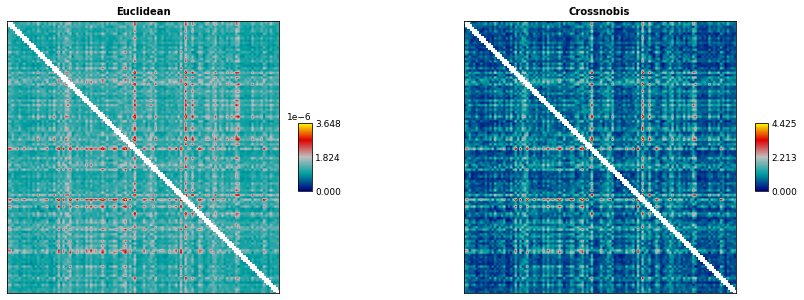

In [144]:
noise_prec_diag = rsa.data.noise.prec_from_measurements(dataset, obs_desc='conds', method='diag')
rdm_euc_untrained = rsa.rdm.calc_rdm(dataset, descriptor='conds', method='euclidean')
rdm_maha_shrink_untrained = rsa.rdm.calc_rdm(dataset, descriptor='conds', method='crossnobis',noise=noise_prec_diag)
rsa.vis.show_rdm(
    rsa.rdm.RDMs(
        np.concatenate(
            [rdm_euc_untrained.get_matrices(),
             rdm_maha_shrink_untrained.get_matrices()],
            axis=0),
        rdm_descriptors=dict(method=('Euclidean', 'Crossnobis'))
    ),
    show_colorbar='panel',
    rdm_descriptor='method',
    vmin=0,
    n_row=1,
    figsize=(15,5)
)[0].set_facecolor('white')

In [146]:
rsa.rdm.compare(rdm_maha_shrink_untrained,rdm_euc,method='cosine_cov')

array([[0.19739242]])